Import libraries

In [1]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2020-12-08 02:16:05--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-12-08 02:16:05--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://netactuate.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-12-08 02:16:05--  https://netactuate.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving netactuate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

Import data and save the time for plotting

In [2]:
# Importing Training Set
daily_url = 'https://raw.githubusercontent.com/cybertraining-dsc/fa20-523-313/main/dailydf.csv'
dataset_train = pd.read_csv(daily_url)

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[2:10]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (5014, 10)
All timestamps == 5014
Featured selected: ['Open', 'High', 'Low', 'Close', 'Volume', 'macd', 'macdsignal', 'macdhist']


Data Pre-processing

In [3]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (5014, 8).


array([[ 5.30062012e+02,  5.36622009e+02,  5.25768982e+02, ...,
        -2.74837737e+01, -3.01063874e+01,  2.62261364e+00],
       [ 5.28206970e+02,  5.30961975e+02,  5.24807983e+02, ...,
        -2.82201012e+01, -2.99078310e+01,  1.68772974e+00],
       [ 5.26299988e+02,  5.26395996e+02,  5.19213013e+02, ...,
        -2.87827090e+01, -2.97893971e+01,  1.00668810e+00],
       ...,
       [ 5.44910107e+03,  5.46656397e+03,  5.42763184e+03, ...,
         7.69831889e+01,  2.76715819e+01,  4.93116070e+01],
       [ 5.50003418e+03,  5.51967920e+03,  5.46245996e+03, ...,
         8.50493625e+01,  3.37113483e+01,  5.13380141e+01],
       [ 5.51658008e+03,  5.56253711e+03,  5.51551904e+03, ...,
         9.34155699e+01,  3.99960032e+01,  5.34195667e+01]])

In [4]:
from sklearn.model_selection import train_test_split
# Feature Scaling
from sklearn.preprocessing import StandardScaler

#training_set, testing_set = train_test_split(training_set, train_size=0.80, test_size = 0.20, shuffle = False)

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])


array([[-1.26220804],
       [-1.26311272],
       [-1.26404274],
       ...,
       [ 1.13675789],
       [ 1.16159745],
       [ 1.16966672]])

In [108]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 10   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    #X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])
#X_train takes the Open, High, Low, and Close, to predict y_train which is the Open price for 60 days after
X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (4915, 90, 8).
y_train shape == (4915, 1).


In [7]:
X_train[-1:]

array([[[ 1.43560688e+00,  1.43099354e+00,  1.44420445e+00,
          1.44453427e+00,  1.95923862e-02,  6.55992979e-01,
          7.80824045e-01, -3.00365461e-01],
        [ 1.44829041e+00,  1.43263229e+00,  1.43211963e+00,
          1.42354084e+00,  3.60639585e-02,  6.44026160e-01,
          7.70334316e-01, -3.07229317e-01],
        [ 1.41654588e+00,  1.40117415e+00,  1.38803128e+00,
          1.38563911e+00,  1.32539123e-02,  5.81998255e-01,
          7.54086358e-01, -4.68148436e-01],
        [ 1.38233745e+00,  1.38910376e+00,  1.39675602e+00,
          1.40411065e+00,  6.12261685e-02,  5.48163947e-01,
          7.35805478e-01, -5.24960352e-01],
        [ 1.41408854e+00,  1.40745559e+00,  1.41291746e+00,
          1.40570933e+00,  6.41250110e-02,  5.17743907e-01,
          7.16083403e-01, -5.65235907e-01],
        [ 1.40087418e+00,  1.38559024e+00,  1.40595835e+00,
          1.39997037e+00,  9.10964912e-03,  4.81024402e-01,
          6.94374901e-01, -6.20748478e-01],
        [ 1.3947

LSTM Model

In [22]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [109]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
#model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1])))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

Training

In [110]:
#%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256) #

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.1524
Epoch 00001: val_loss improved from inf to 0.13202, saving model to weights.h5
16/16 [==============================] - 5s 335ms/step - loss: 0.1524 - val_loss: 0.1320
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.0376
Epoch 00002: val_loss improved from 0.13202 to 0.10966, saving model to weights.h5
16/16 [==============================] - 4s 231ms/step - loss: 0.0376 - val_loss: 0.1097
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.0304
Epoch 00003: val_loss improved from 0.10966 to 0.07858, saving model to weights.h5
16/16 [==============================] - 4s 229ms/step - loss: 0.0304 - val_loss: 0.0786
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.0286
Epoch 00004: val_loss improved from 0.07858 to 0.05363, saving model to weights.h5
16/16 [==============================] - 4s 230ms/step - loss: 0.0286 - val_loss: 0.0536
Epoch 5/100


<Figure size 432x288 with 0 Axes>

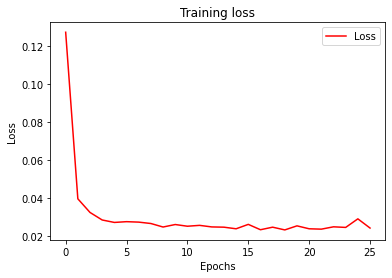

<Figure size 432x288 with 0 Axes>

In [11]:
epochloss=history.history['loss']
epochs=range(len(epochloss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, epochloss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()


Make Prediction

In [102]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

#create dates for the prediction data, from the end of the training data (the original code didn't split train and test)

In [13]:
print(datelist_future)

[Timestamp('2020-11-17 00:00:00', freq='D'), Timestamp('2020-11-18 00:00:00', freq='D'), Timestamp('2020-11-19 00:00:00', freq='D'), Timestamp('2020-11-20 00:00:00', freq='D'), Timestamp('2020-11-21 00:00:00', freq='D'), Timestamp('2020-11-22 00:00:00', freq='D'), Timestamp('2020-11-23 00:00:00', freq='D'), Timestamp('2020-11-24 00:00:00', freq='D'), Timestamp('2020-11-25 00:00:00', freq='D'), Timestamp('2020-11-26 00:00:00', freq='D'), Timestamp('2020-11-27 00:00:00', freq='D'), Timestamp('2020-11-28 00:00:00', freq='D'), Timestamp('2020-11-29 00:00:00', freq='D'), Timestamp('2020-11-30 00:00:00', freq='D'), Timestamp('2020-12-01 00:00:00', freq='D')]


In [103]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

#predictions_future: predict beyond the train dataset, used the last 60 X_train datasets to predict 60 days after the train dataset. Remember that each X_train has 90 days past price data 
#predictions_train: estimation based on the training dataset

In [ ]:
len(X_train)

4933

sas

In [104]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%m/%d/%Y'), '%m/%d/%Y')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Open
2001-01-25,439.252441
2001-01-26,439.217529
2001-01-29,439.755371


In [ ]:
print(dataset_train)

             Open         High          Low        Close    Adj Close
0      677.473999   704.031982   677.473999   700.218018   700.197266
1      694.859009   694.859009   674.336975   678.086975   678.066895
2      681.297974   691.887024   681.297974   688.520996   688.500549
3      691.924011   704.541992   691.924011   696.002991   695.982361
4      696.293030   698.145020   686.705017   690.164001   690.143494
...           ...          ...          ...          ...          ...
5077  5475.564941  5520.908203  5471.591797  5509.513184  5509.513184
5078  5494.484863  5500.416016  5449.796875  5458.602051  5458.602051
5079  5449.101074  5466.563965  5427.631836  5461.058105  5461.058105
5080  5500.034180  5519.679199  5462.459961  5494.872070  5494.872070
5081  5516.580078  5562.537109  5515.519043  5529.939941  5529.939941

[5082 rows x 5 columns]


In [105]:
#dataset_train['Date'] = pd.to_datetime(daily_df.Date,format='%m/%d/%Y')
new_dataset_for_index = pd.read_csv(daily_url)
new_dataset_for_index['Date'] = pd.to_datetime(new_dataset_for_index.Date,format='%m/%d/%Y')
dataset_train.index = new_dataset_for_index['Date']



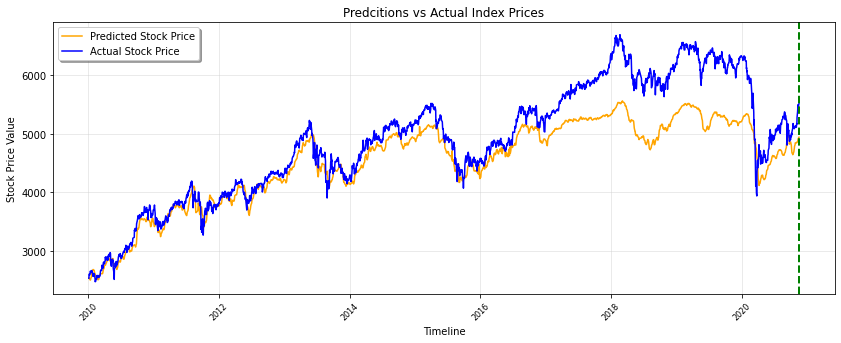

In [106]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2010-01-02'#'2012-06-01'

#plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Predicted Stock Price')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions vs Actual Index Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [107]:
import math
import statistics
rmse = np.sqrt(np.mean(np.power((PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'] - dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open']),2)))
print(rmse)

497.74148656243455


In [31]:
np.std(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'])

735.9581909179688

In [ ]:
rmse_data = [237.27992208443038, 284.9566745755555, 301.5676941715585, 243.8271231027964, 399.23372008004475, 426.0977279370312, 490.43701141979227, 281.33161353781526, 497.74148656243455,   583.0930105074565]